The aim of the project:
The police department of Uk has a stop and search policy for every police department, that’s supposed to ensure that officers stop people and cars when there is probable cause. There have been accusations in the press that the police tend to stop and search certain minorities at a higher rate than others and  that women of certain age groups and ethnicities are searched more than others. 
They collected information on the search operations since 2017, with the following features (https://storage.googleapis.com/capstone4ldsaa/train.csv): 
Age range,
Date,
Gender,
Latitude,
Legislation,
Longitude,
Object of search,
Officer-defined ethnicity,
Outcome,
Outcome linked to object of search,
Part of a policing operation,
Removal of more than just outer clothing,
Self-defined ethnicity,
Type,
Station,
where the training dataset has approximately 660,000 observations.

We must see whether the data proves any of these claims. We also need to create and host an API endpoint for authorizing searches. This will be integrated into a police system that the officer will need to use, ensuring uniformity of decisions. we will be responsible for setting this system up, and running it for a year. 


In [1]:
import json
import joblib
import pickle
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score,f1_score,accuracy_score
import matplotlib.pyplot as plt
from uuid import uuid4
from flask import Flask, jsonify, request
import requests
from imblearn.over_sampling import SMOTE
import dateutil
import datetime

In [2]:
df = pd.read_csv("train.csv")
df.head()

,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station
0,34d76816-cfc2-4bdd-b3a2-bf0c40b12689,Person search,2019-12-01T00:00:00+00:00,True,NaN,NaN,Male,18-24,Asian/Asian British - Any other Asian background,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,False,devon-and-cornwall
1,83c87ec1-e6d4-4bbb-8e0c-159516706359,Person search,2019-12-01T00:09:00+00:00,True,NaN,NaN,Male,18-24,NaN,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,False,devon-and-cornwall
2,8c2eae4b-035a-492f-92d6-cd27e6c900a1,Person search,2019-12-01T00:10:00+00:00,True,NaN,NaN,Female,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,False,devon-and-cornwall
3,e63a036a-a728-4efe-8e08-7198f56d6d0a,Person search,2019-12-01T00:10:00+00:00,False,NaN,NaN,Male,18-24,NaN,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,False,devon-and-cornwall
4,40c70aca-1f7f-4efe-8c5b-ade0f2e9937d,Person search,2019-12-01T00:12:00+00:00,True,50.368247,-4.126646,Male,18-24,NaN,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,False,devon-and-cornwall


In [3]:
df.shape

(660611, 16)

In [4]:
df.columns

Index(['observation_id', 'Type', 'Date', 'Part of a policing operation',
       'Latitude', 'Longitude', 'Gender', 'Age range',
       'Self-defined ethnicity', 'Officer-defined ethnicity', 'Legislation',
       'Object of search', 'Outcome', 'Outcome linked to object of search',
       'Removal of more than just outer clothing', 'station'],
      dtype='object')

# Information about dataframe

In [5]:
df.shape

(660611, 16)

In [6]:
df.columns

Index(['observation_id', 'Type', 'Date', 'Part of a policing operation',
       'Latitude', 'Longitude', 'Gender', 'Age range',
       'Self-defined ethnicity', 'Officer-defined ethnicity', 'Legislation',
       'Object of search', 'Outcome', 'Outcome linked to object of search',
       'Removal of more than just outer clothing', 'station'],
      dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660611 entries, 0 to 660610
Data columns (total 16 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   observation_id                            660611 non-null  object 
 1   Type                                      660611 non-null  object 
 2   Date                                      660611 non-null  object 
 3   Part of a policing operation              507047 non-null  object 
 4   Latitude                                  548295 non-null  float64
 5   Longitude                                 548295 non-null  float64
 6   Gender                                    660611 non-null  object 
 7   Age range                                 660611 non-null  object 
 8   Self-defined ethnicity                    655037 non-null  object 
 9   Officer-defined ethnicity                 660611 non-null  object 
 10  Legislation         

In [8]:
660611-234062

426549

In [9]:
#Results: 

# Information about columns

Observation_id

In [10]:
df['observation_id'].value_counts()

065145d3-668b-48c3-aae9-76aff05d2ef1    1
c6b19126-0f68-4a0d-bd98-73dcb9ee3d72    1
553142f3-995a-4e68-af81-b4551410b68e    1
0cb87f05-4845-47d9-8b58-31a70b16ac5a    1
889ef123-314a-429a-93f3-73d2aa21abf2    1
                                       ..
e927cae8-5ed6-4740-bf66-21a02ef0dc30    1
129b22c4-be27-4fd3-b91c-d36d4856a2dd    1
18b9a6f3-6cbe-4f95-9893-1a7fed11d27b    1
11a8f644-f743-4b0f-bbda-7f73f6a82b68    1
00612de8-46ee-4810-8f84-a976158a1392    1
Name: observation_id, Length: 660611, dtype: int64

In [11]:
#Decision : remove observation_id because it is unique(len of series is equal to the number of rows of df) and do not add anything to our model

Type

In [12]:
df.Type.unique()

array(['Person search', 'Person and Vehicle search', 'Vehicle search'],
      dtype=object)

In [13]:
df.Type.value_counts()

Person search                503503
Person and Vehicle search    156156
Vehicle search                  952
Name: Type, dtype: int64

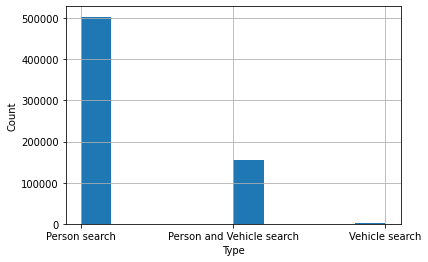

In [14]:
df.Type.hist()
plt.xlabel('Type');
plt.ylabel('Count');

Part of a policing operation

In [15]:
df['Part of a policing operation'].unique()

array([True, False, nan], dtype=object)

In [16]:
df['Part of a policing operation'].value_counts()

False    490773
True      16274
Name: Part of a policing operation, dtype: int64

In [17]:
df['Part of a policing operation'].isnull().sum()

153564

Text(0, 0.5, 'Count')

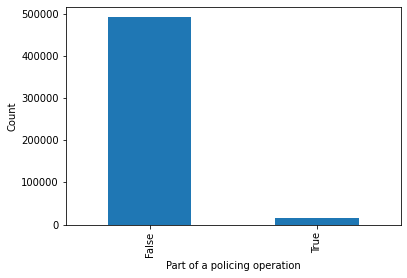

In [18]:
df['Part of a policing operation'].value_counts().plot.bar()
plt.xlabel('Part of a policing operation')
plt.ylabel('Count')

In [19]:
#Decision : I need more information about this column

Latitude, Langitude, station

In [20]:
df.loc[:,['Latitude','Longitude','station']].isnull().sum()

Latitude     112316
Longitude    112316
station           0
dtype: int64

In [21]:
df.Latitude.value_counts()

51.378427    1286
51.402747    1243
51.539189    1104
51.522956     830
51.516120     827
             ... 
50.819422       1
52.016083       1
52.266771       1
53.232820       1
51.517360       1
Name: Latitude, Length: 103638, dtype: int64

In [22]:
df.loc[:,['Latitude','Longitude','station']].tail(n=40)

,Latitude,Longitude,station
660571,51.372929,-2.125311,wiltshire
660572,51.254789,-2.195532,wiltshire
660573,51.303239,-2.228645,wiltshire
660574,51.303239,-2.228645,wiltshire
660575,51.068597,-1.796761,wiltshire
660576,51.458875,-2.121041,wiltshire
660577,51.458875,-2.121041,wiltshire
660578,51.458875,-2.121041,wiltshire
660579,51.458875,-2.121041,wiltshire
660580,NaN,NaN,wiltshire


In [23]:
df.Latitude.min()

49.892149

In [24]:
df.Latitude.max()

57.14385600000001

In [25]:
df.Longitude.min()

-8.053397

In [26]:
df.Longitude.max()

1.7564799999999998

In [27]:
df.station.value_counts()

metropolitan          351294
merseyside             41597
essex                  19039
thames-valley          17898
west-yorkshire         17144
hampshire              13963
hertfordshire          13328
kent                   13309
south-yorkshire        13165
surrey                 10972
avon-and-somerset      10015
btp                     9555
lancashire              9154
west-mercia             7904
devon-and-cornwall      7569
staffordshire           7318
nottinghamshire         7103
northumbria             7049
sussex                  6941
north-wales             5215
lincolnshire            5047
leicestershire          4980
greater-manchester      4851
cheshire                4845
norfolk                 4779
dyfed-powys             4315
bedfordshire            4209
humberside              3783
city-of-london          3575
northamptonshire        3526
suffolk                 3355
warwickshire            3249
gloucestershire         2871
derbyshire              2852
dorset        

In [28]:
##I keep all 3 features and fill nans with strategy mean() for latitude and Langitude

Gender

In [29]:
df.Gender.value_counts()

Male      605422
Female     54812
Other        377
Name: Gender, dtype: int64

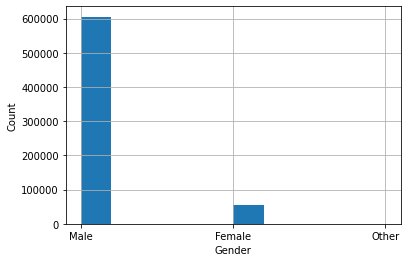

In [30]:
df.Gender.hist()
plt.xlabel('Gender');
plt.ylabel('Count');

In [31]:
df[df.Gender=='Other'].Outcome.value_counts()

A no further action disposal               267
Arrest                                      39
Community resolution                        23
Nothing found - no further action           14
Khat or Cannabis warning                     9
Summons / charged by post                    7
Caution (simple or conditional)              5
Offender given drugs possession warning      4
Suspect arrested                             4
Penalty Notice for Disorder                  4
Suspect summonsed to court                   1
Name: Outcome, dtype: int64

In [32]:
df[df.Gender=='Other']['Age range'].value_counts()

18-24       126
10-17        85
25-34        83
over 34      80
under 10      3
Name: Age range, dtype: int64

In [33]:
#Result
#There's a clear disparity between samples for each gender,
#this might be a problem not only to train the model but to efficiently analyze its biases.
# there is also other group wich can be removed from our analysis or can be go to the F group
#Remove Other from analysis

In [34]:
df.columns

Index(['observation_id', 'Type', 'Date', 'Part of a policing operation',
       'Latitude', 'Longitude', 'Gender', 'Age range',
       'Self-defined ethnicity', 'Officer-defined ethnicity', 'Legislation',
       'Object of search', 'Outcome', 'Outcome linked to object of search',
       'Removal of more than just outer clothing', 'station'],
      dtype='object')

Age range

In [35]:
df['Age range'].value_counts()

18-24       241905
25-34       158181
10-17       131763
over 34     128378
under 10       384
Name: Age range, dtype: int64

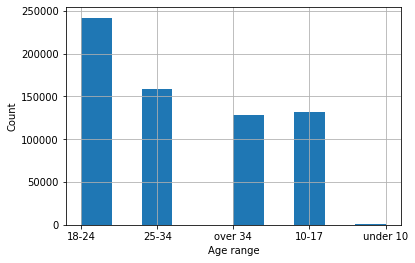

In [36]:
#remove under 10 age
df['Age range'].hist()
plt.xlabel('Age range');
plt.ylabel('Count');

In [37]:
df.loc[df['Age range']=='under 10',:]

,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station
429,ea483461-7a08-4e70-aa6a-4a25e61ddef1,Person search,2019-12-11T00:00:00+00:00,NaN,NaN,NaN,Male,under 10,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,False,dyfed-powys
779,cfc269b8-e34d-4239-a4dc-f052b56a8022,Person search,2019-12-04T17:30:00+00:00,False,NaN,NaN,Female,under 10,White - Any other White background,White,Police and Criminal Evidence Act 1984 (section 1),Stolen goods,A no further action disposal,NaN,False,bedfordshire
791,0f8419da-0c79-4140-9834-cf930682be2a,Person search,2019-12-06T12:30:00+00:00,True,51.916449,-0.662798,Male,under 10,White - Irish,White,Police and Criminal Evidence Act 1984 (section 1),Article for use in theft,Community resolution,True,False,bedfordshire
5119,82bacd9c-c038-431d-a865-a0285efa3635,Person search,2019-12-24T19:33:00+00:00,False,52.603583,0.361754,Male,under 10,White - English/Welsh/Scottish/Northern Irish/...,White,Police and Criminal Evidence Act 1984 (section 1),Article for use in theft,A no further action disposal,False,False,norfolk
5566,2dac968f-0102-4943-bba4-a3375f876c2d,Person and Vehicle search,2019-12-05T21:20:00+00:00,False,NaN,NaN,Male,under 10,White - English/Welsh/Scottish/Northern Irish/...,White,NaN,Article for use in theft,A no further action disposal,NaN,NaN,thames-valley
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658660,d6afe90a-dedf-4732-b3ac-a910cc11f895,Person search,2018-08-09T20:11:00+00:00,False,53.579219,-2.462290,Female,under 10,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,NaN,False,greater-manchester
658733,a0c06e71-86a4-4870-9581-712a3e0f4102,Person and Vehicle search,2018-08-18T21:01:00+00:00,False,53.581433,-2.402079,Male,under 10,Asian/Asian British - Indian,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Community resolution,True,False,greater-manchester
658741,b67a2798-6e83-4bb4-8506-ed63dfd5aae8,Person search,2018-08-20T01:40:00+00:00,False,53.557421,-2.136697,Male,under 10,White - English/Welsh/Scottish/Northern Irish/...,White,Police and Criminal Evidence Act 1984 (section 1),Article for use in theft,A no further action disposal,NaN,False,greater-manchester
659332,7f084687-3720-4899-9659-c254187d39dc,Person search,2018-08-27T10:15:00+00:00,NaN,51.541790,-0.002183,Male,under 10,Black/African/Caribbean/Black British - Any ot...,Black,Criminal Justice and Public Order Act 1994 (se...,Offensive weapons,A no further action disposal,True,False,btp


In [38]:
df.loc[df['Age range']=='under 10',:].Outcome.value_counts()

A no further action disposal                    284
Arrest                                           31
Community resolution                             21
Nothing found - no further action                15
Khat or Cannabis warning                         14
Summons / charged by post                         5
Penalty Notice for Disorder                       4
Local resolution                                  3
Caution (simple or conditional)                   3
Suspect arrested                                  2
Offender given drugs possession warning           1
Article found - Detailed outcome unavailable      1
Name: Outcome, dtype: int64

In [39]:
#Comment: The number of under 10 is very low(384) and among them 284 person are inocent. 
#It will effect on the analysis later on. There is bias in the date 

Self-defined ethnicity

In [40]:
df['Self-defined ethnicity'].value_counts()

White - English/Welsh/Scottish/Northern Irish/British                                   272053
Other ethnic group - Not stated                                                          86421
White - Any other White background                                                       57875
Black/African/Caribbean/Black British - Any other Black/African/Caribbean background     54036
Black/African/Caribbean/Black British - African                                          43297
Black/African/Caribbean/Black British - Caribbean                                        31315
Asian/Asian British - Any other Asian background                                         29169
Asian/Asian British - Bangladeshi                                                        17083
Asian/Asian British - Pakistani                                                          15720
Other ethnic group - Any other ethnic group                                              11276
Mixed/Multiple ethnic groups - Any other Mixed/Mul

In [41]:
df['Self-defined ethnicity'].isnull().sum()

5574

<AxesSubplot:>

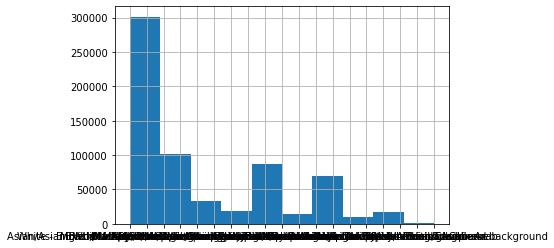

In [42]:
df['Self-defined ethnicity'].hist()

In [43]:
B = df['Self-defined ethnicity'].value_counts().values[3]+df['Self-defined ethnicity'].value_counts().values[4]+df['Self-defined ethnicity'].value_counts().values[5]
print("the number of blacks in Self-defined ethnicity is :{}".format(B))

the number of blacks in Self-defined ethnicity is :128648


In [44]:
W = df['Self-defined ethnicity'].value_counts().values[0]+df['Self-defined ethnicity'].value_counts().values[2]+df['Self-defined ethnicity'].value_counts().values[13]+df['Self-defined ethnicity'].value_counts().values[17]
print("the number of whites in Self-defined ethnicity is :{}".format(W))

the number of whites in Self-defined ethnicity is :335742


In [45]:
A = df['Self-defined ethnicity'].value_counts().values[6]+df['Self-defined ethnicity'].value_counts().values[7]+df['Self-defined ethnicity'].value_counts().values[8]+df['Self-defined ethnicity'].value_counts().values[11]+df['Self-defined ethnicity'].value_counts().values[16]
print("the number of asians in Self-defined ethnicity is :{}".format(A))

the number of asians in Self-defined ethnicity is :71092


In [46]:
#It has 5574 null and presenting this column will not effect on the analysis we just use officer defined etnicity
#Decision: remove self defined ethnicity

Officer-defined ethnicity

In [47]:
df['Officer-defined ethnicity'].value_counts()

White    378311
Black    174593
Asian     86035
Other     19842
Mixed      1830
Name: Officer-defined ethnicity, dtype: int64

Text(0, 0.5, 'Count')

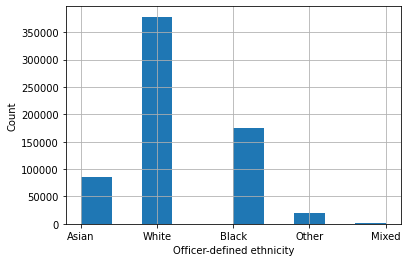

In [48]:
df['Officer-defined ethnicity'].hist()
plt.xlabel('Officer-defined ethnicity')
plt.ylabel('Count')

In [49]:
#Comment:Mixed is bias I need to do something for that. Other also is bias.

Legislation

In [50]:
df['Legislation'].value_counts()

Misuse of Drugs Act 1971 (section 23)                      385307
Police and Criminal Evidence Act 1984 (section 1)          224682
Criminal Justice and Public Order Act 1994 (section 60)     17259
Firearms Act 1968 (section 47)                               4352
Criminal Justice Act 1988 (section 139B)                      746
Poaching Prevention Act 1862 (section 2)                      152
Psychoactive Substances Act 2016 (s36(2))                      90
Wildlife and Countryside Act 1981 (section 19)                 31
Police and Criminal Evidence Act 1984 (section 6)              15
Aviation Security Act 1982 (section 27(1))                     11
Customs and Excise Management Act 1979 (section 163)           10
Crossbows Act 1987 (section 4)                                  5
Protection of Badgers Act 1992 (section 11)                     4
Psychoactive Substances Act 2016 (s37(2))                       4
Conservation of Seals Act 1970 (section 4)                      1
Deer Act 1

In [51]:
#One hot encoder
# remove under 10 values

Object of search

In [52]:
df['Object of search'].value_counts()

Controlled drugs                              398873
Offensive weapons                             102107
Stolen goods                                   67636
Article for use in theft                       30836
Evidence of offences under the Act             19911
Anything to threaten or harm anyone            19762
Articles for use in criminal damage            11060
Firearms                                        5479
Fireworks                                       2948
Psychoactive substances                         1701
Detailed object of search unavailable            129
Game or poaching equipment                       102
Evidence of wildlife offences                     25
Goods on which duty has not been paid etc.        23
Crossbows                                         17
Seals or hunting equipment                         2
Name: Object of search, dtype: int64

In [53]:
#one hot encoder we will use

Outcome

In [54]:
df['Outcome'].value_counts()

A no further action disposal                                    455342
Arrest                                                           94118
Community resolution                                             41311
Khat or Cannabis warning                                         17173
Nothing found - no further action                                16188
Summons / charged by post                                        12232
Penalty Notice for Disorder                                      11214
Suspect arrested                                                  4649
Caution (simple or conditional)                                   3179
Offender given drugs possession warning                           2102
Local resolution                                                  1333
Suspect summonsed to court                                         636
Article found - Detailed outcome unavailable                       524
Offender given penalty notice                                      414
Offend

In [55]:
 print("The totall number of no action after searching is:{}".format(df['Outcome'].value_counts()[0]+df['Outcome'].value_counts()[4]))

The totall number of no action after searching is:471530


In [56]:
#We built our target according to this so it will be removed form analysis

Outcome linked to object of search


In [57]:
df['Outcome linked to object of search'].value_counts()

True     100273
False     87238
Name: Outcome linked to object of search, dtype: int64

In [58]:
df['Outcome linked to object of search'].isnull().sum()

473100

In [59]:
df['Outcome linked to object of search'].unique()

array([nan, True, False], dtype=object)

Text(0, 0.5, 'Count')

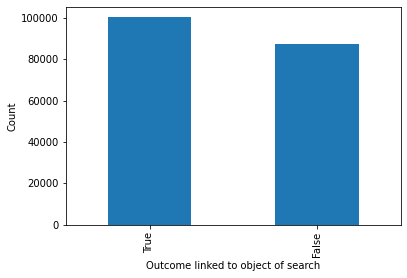

In [60]:
df['Outcome linked to object of search'].value_counts().plot.bar()
plt.xlabel('Outcome linked to object of search')
plt.ylabel('Count')

Removal of more than just outer clothing

In [61]:
print("The number of nan vaues in the 'Outcome linked to object of search' column is :{}".format(df['Outcome linked to object of search'].isnull().sum()))

The number of nan vaues in the 'Outcome linked to object of search' column is :473100


In [62]:
#Decision: This column will be considered by target the target is true if this column related to search object is true and 
#outcome be  Local resolution
#Community resolution
#Offender given drugs possession warning
#Khat or Cannabis warning
#Caution (simple or conditional)
#Offender given penalty notice
#Arrest
#Penalty Notice for Disorder
#Suspected psychoactive substances seized - No further action
#Summons / charged by post
#Article found - Detailed outcome unavailable
#Offender cautioned
#Suspect arrested
#Suspect summonsed to court


Removal of more than just outer clothing

In [63]:
df['Removal of more than just outer clothing'].isnull().sum()

426549

In [64]:
df['Removal of more than just outer clothing'].unique()

array([False, True, nan], dtype=object)

In [65]:
df['Removal of more than just outer clothing'].value_counts()

False    223397
True      10665
Name: Removal of more than just outer clothing, dtype: int64

Text(0, 0.5, 'Count')

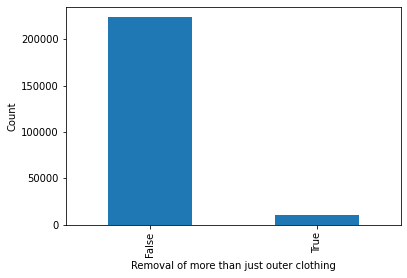

In [66]:
#information of this column is  baias
df['Removal of more than just outer clothing'].value_counts().plot.bar()
plt.xlabel('Removal of more than just outer clothing')
plt.ylabel('Count')

In [67]:
#Bias how we could decide according to this value will be difficult.

Station

In [68]:
df['station'].value_counts()

metropolitan          351294
merseyside             41597
essex                  19039
thames-valley          17898
west-yorkshire         17144
hampshire              13963
hertfordshire          13328
kent                   13309
south-yorkshire        13165
surrey                 10972
avon-and-somerset      10015
btp                     9555
lancashire              9154
west-mercia             7904
devon-and-cornwall      7569
staffordshire           7318
nottinghamshire         7103
northumbria             7049
sussex                  6941
north-wales             5215
lincolnshire            5047
leicestershire          4980
greater-manchester      4851
cheshire                4845
norfolk                 4779
dyfed-powys             4315
bedfordshire            4209
humberside              3783
city-of-london          3575
northamptonshire        3526
suffolk                 3355
warwickshire            3249
gloucestershire         2871
derbyshire              2852
dorset        

In [69]:
len(df['station'].unique())

42

In [70]:
#Keep the station

In [71]:
ddf = df.loc[df['Outcome']=='A no further action disposal',:]
ddf2 = ddf.loc[ddf['Outcome linked to object of search']==True, :]
ddf2

,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station
18,edb0946c-631e-4ad6-b693-46867daf588d,Person search,2019-12-01T15:00:00+00:00,False,51.205296,-4.119489,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,True,False,devon-and-cornwall
53,d4b112da-0ae2-4309-b3fd-7544fb5f6285,Person search,2019-12-05T21:35:00+00:00,False,NaN,NaN,Male,over 34,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,True,False,devon-and-cornwall
76,a3db0267-9d4f-4622-9fe4-6f2667d96bb5,Person search,2019-12-07T01:32:00+00:00,False,NaN,NaN,Male,18-24,NaN,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,True,False,devon-and-cornwall
84,50c84854-d736-45b2-8cb9-0da84562fc2c,Person and Vehicle search,2019-12-07T20:29:00+00:00,False,50.721316,-3.504660,Male,over 34,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,True,False,devon-and-cornwall
108,d2943914-0a03-4e5f-9ce8-0e0036c59e05,Person and Vehicle search,2019-12-10T22:50:00+00:00,False,50.485179,-3.570997,Male,25-34,NaN,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,True,False,devon-and-cornwall
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
659807,2b428f02-b46d-45e0-97a4-93d922a70fd2,Person search,2018-08-04T14:50:00+00:00,False,52.407209,-0.730597,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,True,False,northamptonshire
659826,7966a3be-ce2d-4302-a51b-505958362a53,Person search,2018-08-06T19:25:00+00:00,False,52.246884,-0.881566,Male,10-17,White - Any other White background,White,Police and Criminal Evidence Act 1984 (section 1),Controlled drugs,A no further action disposal,True,False,northamptonshire
659841,424ce924-da09-4c7b-a52f-3bb69d695957,Person search,2018-08-12T18:15:00+00:00,False,52.248944,-0.909624,Female,25-34,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,True,False,northamptonshire
659852,afede363-9220-4c22-b377-f8e7a5f1d2d6,Person search,2018-08-16T08:40:00+00:00,False,52.258832,-0.873046,Male,over 34,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,True,False,northamptonshire


# Target Built(From Outcome)

In [72]:
df['Outcome'].unique()

array(['A no further action disposal', 'Arrest', 'Community resolution',
       'Summons / charged by post', 'Khat or Cannabis warning',
       'Caution (simple or conditional)', 'Penalty Notice for Disorder',
       'Nothing found - no further action',
       'Offender given drugs possession warning', 'Local resolution',
       'Suspect arrested', 'Article found - Detailed outcome unavailable',
       'Offender cautioned', 'Suspect summonsed to court',
       'Offender given penalty notice',
       'Suspected psychoactive substances seized - No further action'],
      dtype=object)

In [73]:
df['Outcome linked to object of search'] = df['Outcome linked to object of search'].fillna(False)

In [74]:
#build target from outcome column true means the search was succesfull and police find something False means the polica did search but could not find anythong.
df['target'] =True
df.loc[df['Outcome']=='A no further action disposal' ,'target'] =False
df.loc[df['Outcome']== 'Nothing found - no further action','target']=False
df.loc[df['Outcome linked to object of search']==False ,'target'] =False
df

,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station,target
0,34d76816-cfc2-4bdd-b3a2-bf0c40b12689,Person search,2019-12-01T00:00:00+00:00,True,NaN,NaN,Male,18-24,Asian/Asian British - Any other Asian background,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,False,devon-and-cornwall,False
1,83c87ec1-e6d4-4bbb-8e0c-159516706359,Person search,2019-12-01T00:09:00+00:00,True,NaN,NaN,Male,18-24,NaN,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,False,devon-and-cornwall,False
2,8c2eae4b-035a-492f-92d6-cd27e6c900a1,Person search,2019-12-01T00:10:00+00:00,True,NaN,NaN,Female,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,False,devon-and-cornwall,False
3,e63a036a-a728-4efe-8e08-7198f56d6d0a,Person search,2019-12-01T00:10:00+00:00,False,NaN,NaN,Male,18-24,NaN,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,False,devon-and-cornwall,False
4,40c70aca-1f7f-4efe-8c5b-ade0f2e9937d,Person search,2019-12-01T00:12:00+00:00,True,50.368247,-4.126646,Male,18-24,NaN,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,False,devon-and-cornwall,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660606,a23dc59d-29fe-48e5-b012-81feb6acfddf,Person search,2018-08-29T02:45:00+00:00,NaN,NaN,NaN,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,NaN,wiltshire,False
660607,425fde18-f7d5-4ebe-baf4-714cadd5a445,Person and Vehicle search,2018-08-29T21:00:00+00:00,False,51.540219,-1.764708,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Penalty Notice for Disorder,True,False,wiltshire,True
660608,7c249ab7-d4bf-47ef-86bd-aad51d7d2aab,Person search,2018-08-29T21:10:00+00:00,False,51.540219,-1.764708,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,False,wiltshire,False
660609,4fa54513-20c4-4a53-a5db-8a4bb85b1e32,Person search,2018-08-29T21:15:00+00:00,False,51.540219,-1.764708,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,False,wiltshire,False


Target chack values

In [75]:
#count the values
df['target'].value_counts()

False    598325
True      62286
Name: target, dtype: int64

Text(0, 0.5, 'Count')

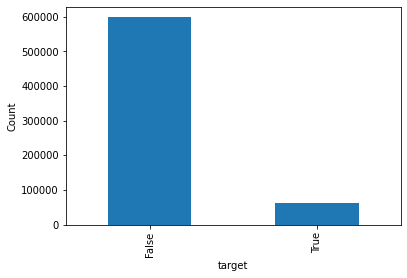

In [76]:
#plot
df['target'].value_counts().plot.bar()
plt.xlabel('target')
plt.ylabel('Count')

In [77]:
df['Outcome linked to object of search'].value_counts()

False    560338
True     100273
Name: Outcome linked to object of search, dtype: int64

# Comparing columns with eachother

In [78]:
df.groupby(['Outcome', 
            'Outcome linked to object of search'])['Legislation'].count().unstack()

Outcome linked to object of search,False,True
Outcome,,
A no further action disposal,399772,35627
Arrest,64495,25800
Article found - Detailed outcome unavailable,242,243
Caution (simple or conditional),793,2231
Community resolution,33389,7192
Khat or Cannabis warning,4160,11561
Local resolution,893,434
Nothing found - no further action,14112,1445
Offender cautioned,48,136


In [79]:
df.groupby(['Object of search', 
            'Outcome linked to object of search'])['Legislation'].count().unstack()

Outcome linked to object of search,False,True
Object of search,,
Anything to threaten or harm anyone,16905.0,1134.0
Article for use in theft,20984.0,7319.0
Articles for use in criminal damage,10215.0,723.0
Controlled drugs,315623.0,65775.0
Crossbows,12.0,5.0
Detailed object of search unavailable,33.0,76.0
Evidence of offences under the Act,19305.0,407.0
Evidence of wildlife offences,12.0,11.0
Firearms,4096.0,761.0


In [80]:
df.groupby(['Officer-defined ethnicity', 
            'Self-defined ethnicity'])['Longitude'].count().unstack()


Self-defined ethnicity,Asian/Asian British - Any other Asian background,Asian/Asian British - Bangladeshi,Asian/Asian British - Chinese,Asian/Asian British - Indian,Asian/Asian British - Pakistani,Black/African/Caribbean/Black British - African,Black/African/Caribbean/Black British - Any other Black/African/Caribbean background,Black/African/Caribbean/Black British - Caribbean,Mixed/Multiple ethnic groups - Any other Mixed/Multiple ethnic background,Mixed/Multiple ethnic groups - White and Asian,Mixed/Multiple ethnic groups - White and Black African,Mixed/Multiple ethnic groups - White and Black Caribbean,Other ethnic group - Any other ethnic group,Other ethnic group - Arab,Other ethnic group - Not stated,White - Any other White background,White - English/Welsh/Scottish/Northern Irish/British,White - Gypsy or Irish Traveller,White - Irish
Officer-defined ethnicity,,,,,,,,,,,,,,,,,,,
Asian,21617,15183,518,6674,11477,371,343,114,956,845,60,59,1462,12,11085,421,637,9,11
Black,586,133,94,124,91,36992,47076,26884,2955,71,1520,5081,1096,5,28072,304,1087,7,38
Mixed,14,2,1,3,8,18,76,44,302,56,93,236,22,2,483,71,63,1,0
Other,2691,71,137,72,172,452,369,44,1500,188,173,313,3693,63,5458,1372,639,3,17
White,534,59,60,114,122,295,419,207,2603,441,175,581,3609,3,27256,48295,213687,592,4167


In [81]:
df.groupby(['Gender', 
            'target'])['Longitude'].count().unstack()

target,False,True
Gender,,
Female,39439,4572
Male,458776,45180
Other,283,45


In [82]:
df.groupby(['Officer-defined ethnicity', 
            'target'])['Longitude'].count().unstack()


target,False,True
Officer-defined ethnicity,,
Asian,68415,3664
Black,147385,5194
Mixed,1223,334
Other,16414,1083
White,265061,39522


In [83]:
df.groupby(['Officer-defined ethnicity', 
            'Removal of more than just outer clothing'])['Longitude'].count().unstack()

Removal of more than just outer clothing,False,True
Officer-defined ethnicity,,
Asian,12304,775
Black,17362,1957
Mixed,1157,93
Other,3496,173
White,145650,5698


In [84]:
df.groupby(['Gender', 
            'Removal of more than just outer clothing'])['Longitude'].count().unstack()

Removal of more than just outer clothing,False,True
Gender,,
Female,17463,1039
Male,162328,7646
Other,178,11


In [85]:
df[df.Gender=='Other'].target.value_counts()

False    329
True      48
Name: target, dtype: int64

In [86]:
df.loc[df[df.station=='metropolitan'].index,['Outcome linked to object of search','Removal of more than just outer clothing']]

,Outcome linked to object of search,Removal of more than just outer clothing
7304,False,NaN
7305,False,NaN
7306,False,NaN
7307,False,NaN
7308,False,NaN
...,...,...
650365,False,NaN
650366,False,NaN
650367,False,NaN
650368,False,NaN


In [87]:
df.loc[df.station=='north-yorkshire',['Outcome linked to object of search','Removal of more than just outer clothing']]

,Outcome linked to object of search,Removal of more than just outer clothing
1788,True,NaN
1789,False,NaN
1790,False,NaN
1791,False,NaN
1792,False,NaN
...,...,...
651257,True,NaN
651258,True,NaN
651259,True,NaN
651260,False,NaN


In [88]:
df.loc[df.station=='cleveland',['Outcome linked to object of search','Removal of more than just outer clothing']]

,Outcome linked to object of search,Removal of more than just outer clothing
1861,False,NaN
1862,False,NaN
1863,False,NaN
1864,False,NaN
1865,True,NaN
...,...,...
656461,True,NaN
656462,False,NaN
656463,True,NaN
656464,True,NaN


# Dealing with datetime features

In [89]:

df['Date'] = pd.to_datetime(df['Date'])

# get the hour and day of the week, maybe they will be useful 
df['hour'] = df['Date'].dt.hour
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day
df

,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station,target,hour,month,day
0,34d76816-cfc2-4bdd-b3a2-bf0c40b12689,Person search,2019-12-01 00:00:00+00:00,True,NaN,NaN,Male,18-24,Asian/Asian British - Any other Asian background,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,False,devon-and-cornwall,False,0,12,1
1,83c87ec1-e6d4-4bbb-8e0c-159516706359,Person search,2019-12-01 00:09:00+00:00,True,NaN,NaN,Male,18-24,NaN,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,False,devon-and-cornwall,False,0,12,1
2,8c2eae4b-035a-492f-92d6-cd27e6c900a1,Person search,2019-12-01 00:10:00+00:00,True,NaN,NaN,Female,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,False,devon-and-cornwall,False,0,12,1
3,e63a036a-a728-4efe-8e08-7198f56d6d0a,Person search,2019-12-01 00:10:00+00:00,False,NaN,NaN,Male,18-24,NaN,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,False,devon-and-cornwall,False,0,12,1
4,40c70aca-1f7f-4efe-8c5b-ade0f2e9937d,Person search,2019-12-01 00:12:00+00:00,True,50.368247,-4.126646,Male,18-24,NaN,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,False,devon-and-cornwall,False,0,12,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660606,a23dc59d-29fe-48e5-b012-81feb6acfddf,Person search,2018-08-29 02:45:00+00:00,NaN,NaN,NaN,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,NaN,wiltshire,False,2,8,29
660607,425fde18-f7d5-4ebe-baf4-714cadd5a445,Person and Vehicle search,2018-08-29 21:00:00+00:00,False,51.540219,-1.764708,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Penalty Notice for Disorder,True,False,wiltshire,True,21,8,29
660608,7c249ab7-d4bf-47ef-86bd-aad51d7d2aab,Person search,2018-08-29 21:10:00+00:00,False,51.540219,-1.764708,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,False,wiltshire,False,21,8,29
660609,4fa54513-20c4-4a53-a5db-8a4bb85b1e32,Person search,2018-08-29 21:15:00+00:00,False,51.540219,-1.764708,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,False,wiltshire,False,21,8,29


In [90]:
#decision: ignoring the time and adding hour month and day_of_week columns from original Date column

# Cleaning the data frame

In [91]:
#remove some rows like other in grnder and metropolitan in station(Later I will write a function for that)

In [92]:
#remove metropolitan station from our analysis
df = df.copy()
mask = df['station']=='metropolitan'
metro_station_index = df[mask].index
df = df.drop(metro_station_index)
df.shape
#remove other from gender from our analysis
mask = df['Gender']=='Other'
Other_Gender_index = df[mask].index
df = df.drop(Other_Gender_index)
df.shape

(309045, 20)

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 309045 entries, 0 to 660610
Data columns (total 20 columns):
 #   Column                                    Non-Null Count   Dtype              
---  ------                                    --------------   -----              
 0   observation_id                            309045 non-null  object             
 1   Type                                      309045 non-null  object             
 2   Date                                      309045 non-null  datetime64[ns, UTC]
 3   Part of a policing operation              155607 non-null  object             
 4   Latitude                                  230021 non-null  float64            
 5   Longitude                                 230021 non-null  float64            
 6   Gender                                    309045 non-null  object             
 7   Age range                                 309045 non-null  object             
 8   Self-defined ethnicity                    30

# build new target according to outcome linked to object of search(This is true target for training)

In [94]:
df['Outcome linked to object of search'].unique()

array([False,  True])

In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 309045 entries, 0 to 660610
Data columns (total 20 columns):
 #   Column                                    Non-Null Count   Dtype              
---  ------                                    --------------   -----              
 0   observation_id                            309045 non-null  object             
 1   Type                                      309045 non-null  object             
 2   Date                                      309045 non-null  datetime64[ns, UTC]
 3   Part of a policing operation              155607 non-null  object             
 4   Latitude                                  230021 non-null  float64            
 5   Longitude                                 230021 non-null  float64            
 6   Gender                                    309045 non-null  object             
 7   Age range                                 309045 non-null  object             
 8   Self-defined ethnicity                    30

In [96]:
df['Outcome'].unique()

array(['A no further action disposal', 'Arrest', 'Community resolution',
       'Summons / charged by post', 'Khat or Cannabis warning',
       'Caution (simple or conditional)', 'Penalty Notice for Disorder',
       'Nothing found - no further action',
       'Offender given drugs possession warning', 'Local resolution',
       'Suspect arrested', 'Article found - Detailed outcome unavailable',
       'Offender cautioned', 'Suspect summonsed to court',
       'Offender given penalty notice',
       'Suspected psychoactive substances seized - No further action'],
      dtype=object)

In [97]:
df[(df['Outcome linked to object of search'] == True) & (df['Outcome'] == 'A no further action disposal') ].shape

(36506, 20)

In [98]:
df[(df['Outcome linked to object of search'] == False) & (df['Outcome'] == 'A no further action disposal') ].shape

(169207, 20)

In [99]:
### Comment:I consider both A no further action disposal and nothing found a no further action disposal as search happend but nothing found!! In the case 'Outcome linked to object of search' == False or none and Outcome ==either A further action disposal or Nothing found ... I remove this data from analysis because it does not have any value int he analysis 

In [100]:
# build new dataframe for training
df_search = df[(df['Outcome linked to object of search'] == True) | (df['Outcome'] == True) ]
#df_search.info()
#df_search['Outcome linked to object of search'].value_counts()
#df_search = df.copy()

In [101]:
df_search.shape

(100210, 20)

In [102]:
df.shape

(309045, 20)

# Check if we have more nonsence data regarding removal cloths and target

In [103]:
df_search.loc[df.station=='north-yorkshire',['Outcome linked to object of search','Removal of more than just outer clothing','target']]

,Outcome linked to object of search,Removal of more than just outer clothing,target
1788,True,NaN,True
1793,True,NaN,True
1799,True,NaN,True
1800,True,NaN,True
1802,True,NaN,True
...,...,...,...
651254,True,NaN,True
651256,True,NaN,True
651257,True,NaN,True
651258,True,NaN,True


In [104]:
df_search.loc[df.station=='cleveland',['Removal of more than just outer clothing']].isnull().sum()

Removal of more than just outer clothing    478
dtype: int64

# Check if after cleaning the outcome ot target is bias

In [105]:
df.target.value_counts()

False    246807
True      62238
Name: target, dtype: int64

<AxesSubplot:>

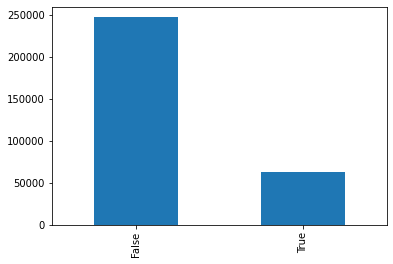

In [106]:
df.target.value_counts().plot.bar()

In [107]:
# check for df_search
df_search['target'].value_counts()

True     62238
False    37972
Name: target, dtype: int64

<AxesSubplot:>

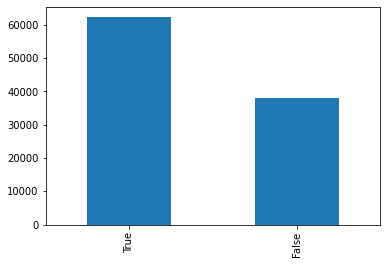

In [108]:
df_search.target.value_counts().plot.bar()

# Percentage of true and false in target for df

In [109]:
len_target = df.shape[0]
target_false_percentage = df.target.value_counts()[0]*100/len_target
target_true_percentage = df.target.value_counts()[1]*100/len_target
print("target_false_percentage:{},target_true_percentage:{}".format(target_false_percentage,target_true_percentage))

target_false_percentage:79.8611852642819,target_true_percentage:20.1388147357181


# Percentage of true and false in target for df_search

In [110]:
len_target = df_search.shape[0]
target_false_percentage = df_search.target.value_counts()[0]*100/len_target
target_true_percentage = df_search.target.value_counts()[1]*100/len_target
print("target_false_percentage:{},target_true_percentage:{}".format(target_false_percentage,target_true_percentage))

target_false_percentage:37.892425905598245,target_true_percentage:62.107574094401755


# Dealing with imbalence datas

In [111]:
smote = SMOTE(sampling_strategy='not majority')

In [112]:
df_search.Gender.unique()

array(['Male', 'Female'], dtype=object)

# Training the model

In [113]:
df_train,df_test = train_test_split(df_search, test_size=0.25, random_state=42,stratify = df_search['target'])

In [114]:
df_train.shape

(75157, 20)

In [115]:
df_test.shape

(25053, 20)

In [116]:
# lowercaes departments and location names
#df['Type'] = df['Type'].apply(lambda x: str(x).lower())
#df['station'] = df['station'].apply(lambda x: str(x).lower())
#df['Officer-defined ethnicity'] = df['Officer-defined ethnicity'].apply(lambda x: str(x).lower())

In [117]:
target = 'target'


all_features = [ "Type","Date","Part of a policing operation","Latitude","Longitude","Gender","Age range","Officer-defined ethnicity","Legislation","Object of search",'station','hour', 'month','day']

numerical_features = ['Latitude', 'Longitude','hour','month','day']
categorical_features_obj = [
   'Type',
       'Gender','Legislation','Object of search', 'Age range',
       'Officer-defined ethnicity',
        'station'
]
categorical_features_bool = ['Part of a policing operation']


numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer_obj = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

categorical_transformer_bool = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat_obj', categorical_transformer_obj, categorical_features_obj),
        ('cat_bool',categorical_transformer_bool, categorical_features_bool)])

#pipeline = make_pipeline(preprocessor,smote,RandomForestClassifier(max_depth=3, min_samples_leaf=.03, class_weight="balanced", random_state=42, n_jobs=-1))
pipeline = make_pipeline(preprocessor,RandomForestClassifier(max_depth=3, min_samples_leaf=.03, class_weight="balanced", random_state=42, n_jobs=-1))


X_train = df_train[all_features]
y_train = df_train[target]

pipeline.fit(X_train, y_train)

X_test = df_test[all_features]
y_test = df_test[target]

y_pred = pipeline.predict(X_test)
y_pred_train = pipeline.predict(X_train)

# To use on other cells
X_train_baseline = X_train.copy()
X_test_baseline = X_test.copy()
y_train_baseline = y_train.copy()
y_test_baseline = y_test.copy()
y_pred_baseline = y_pred.copy()
pipeline_baseline = pipeline

print('roc_auc_score: ', roc_auc_score(y_test, y_pred))
print('f1_score: ', f1_score(y_test, y_pred))
#accuracy is wrong metric for imbalance data
print('acuracy_score: ', accuracy_score(y_test, y_pred))


roc_auc_score:  0.7047514445091052
f1_score:  0.7607981142724346
acuracy_score:  0.7124096914541173


In [118]:
y_pred_proba = pipeline.predict_proba(X_test)
y_pred_proba[:,1]

array([0.55891827, 0.44813508, 0.58220851, ..., 0.49061325, 0.57579174,
       0.55359403])

In [119]:
y_pred

array([ True, False,  True, ..., False,  True,  True])

In [120]:
with open('columns.json', 'w') as fh:
    json.dump(X_train.columns.tolist(), fh)
    

joblib.dump(pipeline, 'pipeline.pickle') 

with open('dtypes.pickle', 'wb') as fh:
    pickle.dump(X_train.dtypes, fh)

# Requierments 

# Minimum 10 percent success rate for searches

In [121]:
def verify_success_rate_above(y_true, y_pred, min_success_rate=0.1):
    """
    Verifies the success rate on a test set is above a provided minimum
    
    
    """
    
    precision = precision_score(y_true, y_pred, pos_label=True)
    is_satisfied = (precision >= min_success_rate)
    
    return is_satisfied, precision


In [122]:
verify_success_rate_above(y_test, y_pred, min_success_rate=0.1)

(True, 0.7868965043609643)

In [123]:
def verify_amount_found(y_true, y_pred):
    """
    Verifies the amout ofpositive search in the test dataset - a.k.a the recall in our test set
    """
    
    recall = recall_score(y_true, y_pred)    
    return recall


In [124]:
verify_amount_found(y_test, y_pred)

0.736375321336761

In [125]:
df.columns

Index(['observation_id', 'Type', 'Date', 'Part of a policing operation',
       'Latitude', 'Longitude', 'Gender', 'Age range',
       'Self-defined ethnicity', 'Officer-defined ethnicity', 'Legislation',
       'Object of search', 'Outcome', 'Outcome linked to object of search',
       'Removal of more than just outer clothing', 'station', 'target', 'hour',
       'month', 'day'],
      dtype='object')

In [126]:
station_names = df_search.station.unique()
station_names

array(['devon-and-cornwall', 'dyfed-powys', 'derbyshire', 'bedfordshire',
       'avon-and-somerset', 'cheshire', 'sussex', 'north-yorkshire',
       'cleveland', 'merseyside', 'north-wales', 'wiltshire', 'norfolk',
       'suffolk', 'thames-valley', 'durham', 'warwickshire',
       'hertfordshire', 'cumbria', 'essex', 'south-yorkshire', 'surrey',
       'staffordshire', 'northamptonshire', 'northumbria',
       'city-of-london', 'nottinghamshire', 'gloucestershire',
       'lincolnshire', 'btp', 'west-yorkshire', 'dorset', 'west-mercia',
       'kent', 'hampshire', 'greater-manchester', 'lancashire',
       'cambridgeshire', 'leicestershire'], dtype=object)

# No police sub-department should have a discrepency bigger than 5 percent between search success rate between protected class

In [127]:
df_search.groupby([ 'station','Officer-defined ethnicity'])['Legislation'].count().unstack()

Officer-defined ethnicity,Asian,Black,Mixed,Other,White
station,,,,,
avon-and-somerset,89.0,389.0,109.0,54.0,2221.0
bedfordshire,207.0,147.0,1.0,6.0,455.0
btp,632.0,2471.0,NaN,146.0,4869.0
cambridgeshire,24.0,14.0,NaN,2.0,140.0
cheshire,34.0,49.0,NaN,6.0,1264.0
city-of-london,247.0,256.0,NaN,28.0,704.0
cleveland,34.0,11.0,NaN,7.0,426.0
cumbria,24.0,19.0,NaN,7.0,1173.0
derbyshire,285.0,258.0,NaN,37.0,2042.0


In [128]:
df_search.groupby([ 'station','Gender'])['Legislation'].count().unstack()

Gender,Female,Male
station,,
avon-and-somerset,319,2543
bedfordshire,61,755
btp,610,7508
cambridgeshire,33,147
cheshire,116,1237
city-of-london,87,1148
cleveland,39,439
cumbria,186,1037
derbyshire,266,2356


In [129]:
df_search.groupby([ 'station','Removal of more than just outer clothing'])['Legislation'].count().unstack()

Removal of more than just outer clothing,False,True
station,,
avon-and-somerset,2653.0,208.0
bedfordshire,441.0,10.0
btp,8099.0,17.0
cambridgeshire,175.0,5.0
cheshire,1271.0,76.0
city-of-london,1176.0,53.0
cumbria,1124.0,95.0
derbyshire,2401.0,221.0
devon-and-cornwall,1923.0,51.0


In [130]:
#sensitive column 'Gender','Officer-defined ethnicity',
def verify_no_discrimination(X_test, y_true, y_pred, sensitive_column='Gender', max_diff=0.05):
    """
    Verifies that no subdeparment has discrimination in between protected races
    
    
    """
    
    departments = X_test['station'].unique() #name of stations [wiltshire,...]
    sensitive_classes = X_test[sensitive_column].unique() # for gender [Female,Male]
    
    is_satisfied = True
    problematic_departments = []
    good_deparments = []
    for department in departments:
        precisions = {}
        for sensitive_class in sensitive_classes:
            mask = (X_test[sensitive_column] == sensitive_class) & (X_test['station'] == department)
            if mask.sum():
                precisions[sensitive_class] = precision_score(y_true[mask], y_pred[mask], pos_label=1)
                
        diff = np.max(list(precisions.values())) - np.min(list(precisions.values()))
        if diff > max_diff:
            is_satisfied = False
            problematic_departments.append((department, diff, precisions))
        else:
            good_deparments.append((department, diff, precisions))

    return is_satisfied, problematic_departments, good_deparments



In [131]:
#descrimination with gender
print("\n\nGender")

is_satisfied, problematic_departments, good_deparments = verify_no_discrimination(
    X_test_baseline, y_test_baseline, y_pred_baseline)
if not is_satisfied:
    print("Requirement failed 😢")
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))

    print("avg diff:", np.mean([p[1] for p in problematic_departments]))
else:
    print("Requirement satisfied! 🚀")

        
print("\nOfficer-defined ethnicity")

is_satisfied, problematic_departments, good_deparments = verify_no_discrimination(
    X_test_baseline, y_test_baseline, y_pred_baseline, sensitive_column='Officer-defined ethnicity')

if not is_satisfied:
    print("Requirement failed 😢")
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))

    print("avg diff:", np.mean([p[1] for p in problematic_departments]))
        
else:
    print("Requirement satisfied! 🚀")



print("Departments analysed: {}".format(len(problematic_departments) + len(good_deparments)))

        



Gender


/home/sonia/.virtualenvs/caps/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Requirement failed 😢
Num problematic departments: 16
Num good departments: 23
avg diff: 0.12704939954739244

Officer-defined ethnicity
Requirement failed 😢
Num problematic departments: 26
Num good departments: 13
avg diff: 0.3400348943513016
Departments analysed: 39


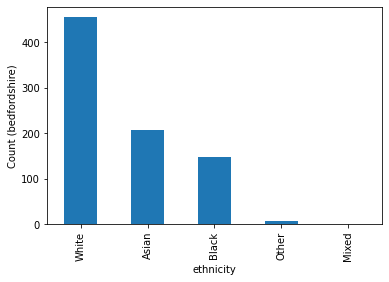

In [132]:
df_search[df_search['station'] == 'bedfordshire']['Officer-defined ethnicity'].value_counts().plot(kind='bar');
plt.xlabel('ethnicity');
plt.ylabel('Count (bedfordshire)');


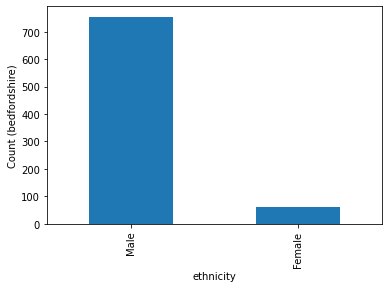

In [133]:
df_search[df_search['station'] == 'bedfordshire']['Gender'].value_counts().plot(kind='bar');
plt.xlabel('ethnicity');
plt.ylabel('Count (bedfordshire)');


This points to the fact that we might have very underepresented classes in our data, and optimizing for those might not be ideal. So we can do a couple of changes to our function:

add a threshold to avoid a small amount of samples to be factored in, only taking into account well represented classes
add a global measure of discrimination
See the implementation below

In [134]:
X_test.Gender.unique()

array(['Male', 'Female'], dtype=object)

In [135]:
def verify_no_discrimination(X_test, y_true, y_pred, sensitive_column='Gender', max_diff=0.05, min_samples=40):
    """
    Verifies that no subdeparment has discrimination in between protected races
    """
    
    departments = X_test['station'].unique()
    sensitive_classes = X_test[sensitive_column].unique()
    
    is_satisfied = True
    problematic_departments = []
    good_deparments = []
    ignored_departments = []
    for department in departments:
        precisions = {}
        for sensitive_class in sensitive_classes:
            mask = (X_test[sensitive_column] == sensitive_class) & (X_test['station'] == department)
            if np.sum(mask) > min_samples:
                precisions[sensitive_class] = precision_score(y_true[mask], y_pred[mask], pos_label=1)
                
        if len(precisions) > 1:    
            diff = np.max(list(precisions.values())) - np.min(list(precisions.values()))

            if diff > max_diff:
                is_satisfied = False
                problematic_departments.append((department, diff, precisions))
            else:
                good_deparments.append((department, diff, precisions))
        else:
            ignored_departments.append((department, None, []))
    
    global_precisions = {}
    for sensitive_class in sensitive_classes:
        mask = (X_test[sensitive_column] == sensitive_class)
        if np.sum(mask) > min_samples:
            global_precisions[sensitive_class] = precision_score(y_true[mask], y_pred[mask], pos_label=1)
    
    if len(precisions) > 1:    
        diff = np.max(list(precisions.values())) - np.min(list(precisions.values()))
        if diff > max_diff:
            is_satisfied = False
        
    return is_satisfied, problematic_departments, good_deparments, global_precisions



In [136]:
#descrimination with gender
print("\n\nGender")

is_satisfied, problematic_departments, good_deparments, global_precisions = verify_no_discrimination(
    X_test_baseline, y_test_baseline, y_pred_baseline)

if not is_satisfied:
    print("Requirement failed 😢")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))

    print("avg diff:", np.mean([p[1] for p in problematic_departments]))
else:
    print("Requirement satisfied! 🚀")

        
print("\n\nOfficer-defined ethnicity")

is_satisfied, problematic_departments, good_deparments, global_precisions = verify_no_discrimination(
    X_test_baseline, y_test_baseline, y_pred_baseline, sensitive_column='Officer-defined ethnicity')

if not is_satisfied:
    print("Requirement failed 😢")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))

    print("avg diff:", np.mean([p[1] for p in problematic_departments]))
else:
    print("Requirement satisfied! 🚀")



print("Departments analysed: {}".format(len(problematic_departments) + len(good_deparments)))        



Gender
Requirement failed 😢
Global rates: {'Male': 0.7948311040580367, 'Female': 0.7078313253012049}
Num problematic departments: 10
Num good departments: 9
avg diff: 0.09247436163945985


Officer-defined ethnicity
Requirement failed 😢
Global rates: {'White': 0.7883712845471927, 'Asian': 0.7789084181313598, 'Other': 0.7670250896057348, 'Black': 0.7925598991172762, 'Mixed': 0.6788990825688074}
Num problematic departments: 12
Num good departments: 9
avg diff: 0.17142473101505984
Departments analysed: 21


In [137]:
df_search[df_search.station=='dorset'].target

30091     True
30094     True
30097     True
30099     True
30103     True
          ... 
656570    True
656571    True
656573    True
656580    True
656582    True
Name: target, Length: 653, dtype: bool

# Removal of more than just outer clothing. we want to see if any station has discrimination of this object  according to gender and age range and ethinicity

Train again with Removal outer clothing feature

In [138]:
target = 'target'


all_features = [
  'Type', 'Part of a policing operation','Latitude', 'Longitude',
       'Gender', 'Legislation','Object of search', 'Age range',
       'Officer-defined ethnicity',
       'Removal of more than just outer clothing', 'station','hour', 'month', 'day'
]

numerical_features = ['Latitude', 'Longitude','hour','month','day']
categorical_features_obj = [
   'Type',
       'Gender','Legislation','Object of search', 'Age range',
       'Officer-defined ethnicity',
        'station'
]
categorical_features_bool = ['Part of a policing operation','Removal of more than just outer clothing']


numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer_obj = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

categorical_transformer_bool = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat_obj', categorical_transformer_obj, categorical_features_obj),
        ('cat_bool',categorical_transformer_bool, categorical_features_bool)])

#pipeline = make_pipeline(preprocessor,smote,RandomForestClassifier(max_depth=3, min_samples_leaf=.03, class_weight="balanced", random_state=42, n_jobs=-1))
pipeline = make_pipeline(preprocessor,RandomForestClassifier(max_depth=3, min_samples_leaf=.03, class_weight="balanced", random_state=42, n_jobs=-1))


X_train = df_train[all_features]
y_train = df_train[target]

pipeline.fit(X_train, y_train)

X_test = df_test[all_features]
y_test = df_test[target]

y_pred = pipeline.predict(X_test)
y_pred_train = pipeline.predict(X_train)

# To use on other cells
X_train_baseline = X_train.copy()
X_test_baseline = X_test.copy()
y_train_baseline = y_train.copy()
y_test_baseline = y_test.copy()
y_pred_baseline = y_pred.copy()
pipeline_baseline = pipeline

print('roc_auc_score: ', roc_auc_score(y_test, y_pred))
print('f1_score: ', f1_score(y_test, y_pred))
#accuracy is wrong metric for imbalance data
print('acuracy_score: ', accuracy_score(y_test, y_pred))


roc_auc_score:  0.7079986349026761
f1_score:  0.7655243068178063
acuracy_score:  0.7168003831876422


In [139]:
#According to analysis below stations "north_yorkshire","cleveland","surrey" and "gwent" 
#did not record information for removal cloths
# so I did not include them in the analysis. The "south_yorkshire" station just record information regarding 
#True removal for both male and female
#which is about 244 over 13165 I considered the rest False for analysis. 
#The "btp" station did not write the true results of removal for woman that by counting
#I discoverd it was 2 so for the analysis I replace 2.

In [140]:
df_search_station=df_search.loc[df.station == "south-yorkshire",: ]

In [141]:
df_search_station.shape

(2143, 20)

In [142]:
df_search_station.groupby([ 'Gender','Removal of more than just outer clothing'])['Legislation'].count().unstack()

Removal of more than just outer clothing,True
Gender,
Female,4
Male,67


In [143]:
df_search_station=df_search.loc[df.station == "btp",: ]

In [144]:
df_search_station.shape

(8118, 20)

In [145]:
df_search_station.groupby([ 'Gender','Removal of more than just outer clothing'])['Legislation'].count().unstack()

Removal of more than just outer clothing,False,True
Gender,,
Female,610.0,NaN
Male,7489.0,17.0


In [146]:
703+8818+29

9550

In [147]:
df_search.station.unique()

array(['devon-and-cornwall', 'dyfed-powys', 'derbyshire', 'bedfordshire',
       'avon-and-somerset', 'cheshire', 'sussex', 'north-yorkshire',
       'cleveland', 'merseyside', 'north-wales', 'wiltshire', 'norfolk',
       'suffolk', 'thames-valley', 'durham', 'warwickshire',
       'hertfordshire', 'cumbria', 'essex', 'south-yorkshire', 'surrey',
       'staffordshire', 'northamptonshire', 'northumbria',
       'city-of-london', 'nottinghamshire', 'gloucestershire',
       'lincolnshire', 'btp', 'west-yorkshire', 'dorset', 'west-mercia',
       'kent', 'hampshire', 'greater-manchester', 'lancashire',
       'cambridgeshire', 'leicestershire'], dtype=object)

In [148]:
for sta in df_search.station.unique():
    df_search_station = pd.DataFrame()
    df_search_station = df_search.loc[df.station == sta,: ]
    display(df_search_station.head(n=1))
    display(df_search_station.groupby([ 'Gender','Removal of more than just outer clothing'])['Legislation'].count().unstack())
    

,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station,target,hour,month,day
16,e6e0ba49-fc76-4949-99cd-c2a6ed7b6b62,Person and Vehicle search,2019-12-01 05:25:00+00:00,False,NaN,NaN,Male,over 34,NaN,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Arrest,True,False,devon-and-cornwall,True,5,12,1


Removal of more than just outer clothing,False,True
Gender,,
Female,276,12
Male,1647,39


,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station,target,hour,month,day
361,f55c7a9b-723c-47f9-b9fb-e1ef155a6a1a,Person search,2019-12-01 00:00:00+00:00,NaN,NaN,NaN,Male,25-34,White - English/Welsh/Scottish/Northern Irish/...,White,Police and Criminal Evidence Act 1984 (section 1),Anything to threaten or harm anyone,A no further action disposal,True,False,dyfed-powys,False,0,12,1


Removal of more than just outer clothing,False,True
Gender,,
Female,15,11
Male,44,24


,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station,target,hour,month,day
581,a39cc20d-c458-4bc7-a263-9ce78e0b1508,Person and Vehicle search,2019-12-01 13:10:00+00:00,NaN,53.433908,-1.993399,Female,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Khat or Cannabis warning,True,False,derbyshire,True,13,12,1


Removal of more than just outer clothing,False,True
Gender,,
Female,242,24
Male,2159,197


,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station,target,hour,month,day
742,db268571-843b-4fed-81c0-fbea3d2d9bab,Person and Vehicle search,2019-12-01 01:05:00+00:00,False,51.884607,-0.45816,Male,18-24,Asian/Asian British - Pakistani,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Community resolution,True,False,bedfordshire,True,1,12,1


Removal of more than just outer clothing,False,True
Gender,,
Female,34.0,NaN
Male,407.0,10.0


,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station,target,hour,month,day
980,3ff6b153-77b2-49ed-a6b2-75af10b992cc,Person search,2019-12-01 00:30:00+00:00,NaN,51.455325,-2.603256,Male,over 34,Other ethnic group - Not stated,Black,Psychoactive Substances Act 2016 (s36(2)),Psychoactive substances,Community resolution,True,False,avon-and-somerset,True,0,12,1


Removal of more than just outer clothing,False,True
Gender,,
Female,296,23
Male,2357,185


,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station,target,hour,month,day
1419,5dc45a1c-b427-45ad-bc60-8577a12a4df5,Person search,2019-12-01 02:48:00+00:00,NaN,53.387276,-2.593075,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Arrest,True,False,cheshire,True,2,12,1


Removal of more than just outer clothing,False,True
Gender,,
Female,106,10
Male,1165,66


,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station,target,hour,month,day
1683,1695ff8d-c915-4930-8633-40cbc8e90d26,Person search,2019-12-05 00:00:00+00:00,False,50.858683,0.564635,Male,25-34,Mixed/Multiple ethnic groups - White and Black...,Asian,Police and Criminal Evidence Act 1984 (section 1),Article for use in theft,Arrest,True,False,sussex,True,0,12,5


Removal of more than just outer clothing,False,True
Gender,,
Female,599,34
Male,3614,170


,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station,target,hour,month,day
1788,37b532e5-e840-46f3-b3e7-908c91786ab4,Person and Vehicle search,2019-12-01 02:12:00+00:00,NaN,53.699211,-1.142087,Male,over 34,Other ethnic group - Not stated,Black,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,Arrest,True,NaN,north-yorkshire,True,2,12,1


Removal of more than just outer clothing
Gender


,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station,target,hour,month,day
1865,5447e288-61ac-41fb-acaf-48710eb0056d,Person and Vehicle search,2019-12-01 03:03:41+00:00,NaN,54.569363,-1.325415,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Police and Criminal Evidence Act 1984 (section 1),Controlled drugs,A no further action disposal,True,NaN,cleveland,False,3,12,1


Removal of more than just outer clothing
Gender


,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station,target,hour,month,day
2015,5f9d1c46-0140-4e41-8a02-c053db5f35a3,Person search,2019-12-01 00:32:12+00:00,NaN,53.445636,-2.910506,Male,18-24,Mixed/Multiple ethnic groups - Any other Mixed...,Other,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Community resolution,True,False,merseyside,True,0,12,1


Removal of more than just outer clothing,False,True
Gender,,
Female,491,22
Male,7679,398


,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station,target,hour,month,day
4427,0adce52d-05e0-450b-8bc3-0c0f3ceedc44,Person search,2019-12-01 13:20:00+00:00,NaN,53.184081,-3.094438,Male,over 34,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,True,False,north-wales,False,13,12,1


Removal of more than just outer clothing,False,True
Gender,,
Female,136,11
Male,991,40


,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station,target,hour,month,day
4821,5c1de394-be96-4b9c-84e8-c9a4a5aeb821,Person and Vehicle search,2019-12-01 00:10:00+00:00,NaN,51.313769,-2.214392,Male,25-34,Black/African/Caribbean/Black British - Any ot...,Black,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Summons / charged by post,True,False,wiltshire,True,0,12,1


Removal of more than just outer clothing,False,True
Gender,,
Female,20,2
Male,151,12


,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station,target,hour,month,day
4884,1332d4c3-2c69-49f2-a7ae-872c38df5317,Person search,2019-12-01 03:53:00+00:00,False,52.637465,1.306904,Male,18-24,Black/African/Caribbean/Black British - African,Black,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,Arrest,True,False,norfolk,True,3,12,1


Removal of more than just outer clothing,False,True
Gender,,
Female,110,6
Male,717,43


,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station,target,hour,month,day
5157,0dd91582-51ee-4d4b-8716-870edbcbc36e,Person search,2019-12-01 15:30:00+00:00,False,52.039809,0.728135,Male,25-34,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Arrest,True,False,suffolk,True,15,12,1


Removal of more than just outer clothing,False,True
Gender,,
Female,90,4
Male,603,102


,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station,target,hour,month,day
5401,8da1722f-33e8-4011-9c50-6a3839ee0ec3,Person and Vehicle search,2019-12-01 01:56:00+00:00,False,NaN,NaN,Male,18-24,Asian/Asian British - Pakistani,Asian,NaN,Controlled drugs,Arrest,True,NaN,thames-valley,True,1,12,1


Removal of more than just outer clothing,False,True
Gender,,
Female,30.0,NaN
Male,313.0,45.0


,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station,target,hour,month,day
6319,0fb68bba-6d0f-429f-b134-b92353a4012a,Person and Vehicle search,2019-12-01 16:01:02+00:00,NaN,54.534814,-1.553841,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Arrest,True,False,durham,True,16,12,1


Removal of more than just outer clothing,False,True
Gender,,
Female,112,9
Male,1323,28


,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station,target,hour,month,day
6427,79f6e91a-bc14-4c4a-8667-7b2c3870513e,Person search,2019-12-01 01:07:28+00:00,False,52.523579,-1.465132,Male,over 34,White - English/Welsh/Scottish/Northern Irish/...,White,Police and Criminal Evidence Act 1984 (section 1),Article for use in theft,A no further action disposal,True,NaN,warwickshire,False,1,12,1


Removal of more than just outer clothing,False,True
Gender,,
Female,41,23
Male,215,104


,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station,target,hour,month,day
6656,c89844f5-652f-431c-9ac8-78a0af9704ed,Person and Vehicle search,2019-12-01 00:00:00+00:00,False,NaN,NaN,Male,18-24,Asian/Asian British - Indian,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Community resolution,True,False,hertfordshire,True,0,12,1


Removal of more than just outer clothing,False,True
Gender,,
Female,224,14
Male,2066,246


,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station,target,hour,month,day
7205,2f36aff8-b413-4b92-a847-64e148579ced,Person search,2019-12-01 00:36:39.650000+00:00,False,54.32731,-2.746003,Male,10-17,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Caution (simple or conditional),True,False,cumbria,True,0,12,1


Removal of more than just outer clothing,False,True
Gender,,
Female,160,26
Male,964,69


,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station,target,hour,month,day
23698,d459dcf3-773c-4d17-bff4-4dc2ac58e947,Person search,2019-12-01 01:01:00+00:00,False,51.771302,0.092636,Male,18-24,Asian/Asian British - Any other Asian background,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Khat or Cannabis warning,True,False,essex,True,1,12,1


Removal of more than just outer clothing,False,True
Gender,,
Female,515,12
Male,4530,218


,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station,target,hour,month,day
24961,41eb58a7-8f8d-490f-88d2-f68eed8fb7a9,Person search,2019-12-01 21:27:00+00:00,False,NaN,NaN,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Arrest,True,NaN,south-yorkshire,True,21,12,1


Removal of more than just outer clothing,True
Gender,
Female,4
Male,67


,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station,target,hour,month,day
25859,075e282c-1fec-4bdd-a684-776148e6c049,Person search,2019-12-01 04:20:00+00:00,False,51.401244,-0.415755,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,NaN,Controlled drugs,Community resolution,True,NaN,surrey,True,4,12,1


Removal of more than just outer clothing
Gender


,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station,target,hour,month,day
26226,b2babf50-bf81-421e-9ba0-dea2e2b8aba9,Person and Vehicle search,2019-12-01 00:23:00+00:00,NaN,53.044182,-2.195234,Male,18-24,Asian/Asian British - Bangladeshi,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Community resolution,True,False,staffordshire,True,0,12,1


Removal of more than just outer clothing,False,True
Gender,,
Female,137,22
Male,1227,203


,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station,target,hour,month,day
26768,ad93075e-a70c-40f2-9914-a91a2808873d,Person search,2019-12-02 16:54:00+00:00,False,52.246643,-0.899954,Male,over 34,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Khat or Cannabis warning,True,False,northamptonshire,True,16,12,2


Removal of more than just outer clothing,False,True
Gender,,
Female,69,3
Male,844,93


,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station,target,hour,month,day
26893,2fc3a982-98c7-4f73-8baa-1afc845f0258,Person search,2019-12-01 00:15:00+00:00,NaN,54.9689,-1.607747,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Summons / charged by post,True,False,northumbria,True,0,12,1


Removal of more than just outer clothing,False,True
Gender,,
Female,404,45
Male,3445,259


,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station,target,hour,month,day
27372,cbcd07be-7f6c-42c8-ad56-85c01c126ea9,Person search,2019-12-01 02:17:49+00:00,NaN,51.513952,-0.085833,Male,over 34,White - Any other White background,Other,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,Arrest,True,False,city-of-london,True,2,12,1


Removal of more than just outer clothing,False,True
Gender,,
Female,86,1
Male,1090,52


,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station,target,hour,month,day
27647,433b89ad-9955-45ef-bdc2-7b10aed2f9da,Person search,2019-12-01 00:30:00+00:00,False,NaN,NaN,Male,10-17,Other ethnic group - Not stated,Black,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,True,True,nottinghamshire,False,0,12,1


Removal of more than just outer clothing,False,True
Gender,,
Female,132,2
Male,2192,98


,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station,target,hour,month,day
28106,d8ad2cac-3fc2-4d38-bc4c-37f949ce2d71,Person and Vehicle search,2019-12-02 00:41:00+00:00,False,51.869002,-2.242224,Male,25-34,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Khat or Cannabis warning,True,NaN,gloucestershire,True,0,12,2


Removal of more than just outer clothing,False,True
Gender,,
Female,137,5
Male,894,38


,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station,target,hour,month,day
28283,101881bf-ce7c-46a8-89ea-35300f8c3d9f,Person and Vehicle search,2019-12-01 16:24:00+00:00,NaN,52.905735,-0.637076,Male,25-34,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Arrest,True,False,lincolnshire,True,16,12,1


Removal of more than just outer clothing,False,True
Gender,,
Female,138,5
Male,1168,58


,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station,target,hour,month,day
28505,3f3c6414-997a-41db-bdaa-8c9189e05972,Person search,2019-12-01 14:45:00+00:00,NaN,52.286246,-1.61213,Male,18-24,Asian/Asian British - Pakistani,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,True,False,btp,False,14,12,1


Removal of more than just outer clothing,False,True
Gender,,
Female,610.0,NaN
Male,7489.0,17.0


,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station,target,hour,month,day
29117,20d0a6ae-4763-435b-9ae8-156fe89fe5a5,Person search,2019-12-01 03:40:00+00:00,False,53.790017,-1.760546,Male,25-34,Asian/Asian British - Pakistani,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,True,False,west-yorkshire,False,3,12,1


Removal of more than just outer clothing,False,True
Gender,,
Female,943,15
Male,12807,228


,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station,target,hour,month,day
30091,6a3bfa46-bb10-4e5a-93e1-c0124d65c547,Person search,2019-12-01 00:00:00+00:00,NaN,50.721844,-1.875951,Male,25-34,Black/African/Caribbean/Black British - Caribbean,Black,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,Arrest,True,False,dorset,True,0,12,1


Removal of more than just outer clothing,False,True
Gender,,
Female,62,13
Male,491,81


,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station,target,hour,month,day
30150,80ab47a5-39f8-4db8-9fb1-81fadebd17de,Person search,2019-12-01 00:24:59+00:00,False,52.718964,-2.742864,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,True,NaN,west-mercia,False,0,12,1


Removal of more than just outer clothing,False,True
Gender,,
Female,100,36
Male,500,237


,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station,target,hour,month,day
30515,7f016990-36f1-4216-abc4-29954c8a9509,Person search,2019-12-01 05:20:00+00:00,False,51.274271,0.521918,Male,18-24,Black/African/Caribbean/Black British - African,Black,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,Arrest,True,False,kent,True,5,12,1


Removal of more than just outer clothing,False,True
Gender,,
Female,178,11
Male,1351,131


,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station,target,hour,month,day
31151,441926bb-e473-49cb-8744-d8be2c0921f8,Person search,2019-12-01 03:50:00+00:00,NaN,50.935303,-1.37828,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Police and Criminal Evidence Act 1984 (section 1),Articles for use in criminal damage,Community resolution,True,False,hampshire,True,3,12,1


Removal of more than just outer clothing,False,True
Gender,,
Female,325,25
Male,2099,199


,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station,target,hour,month,day
33031,14a6f3d2-0b71-4ff3-ac34-936922e1ec3b,Person search,2018-08-31 23:05:00+00:00,False,53.40809,-2.218666,Male,25-34,White - English/Welsh/Scottish/Northern Irish/...,White,Police and Criminal Evidence Act 1984 (section 1),Article for use in theft,Arrest,True,False,greater-manchester,True,23,8,31


Removal of more than just outer clothing,False,True
Gender,,
Female,52,2
Male,786,28


,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station,target,hour,month,day
47221,b8ba27fb-f089-4ce5-ab86-7c7f59764fc8,Person search,2018-09-01 13:58:00+00:00,NaN,53.773556,-2.688411,Male,25-34,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Caution (simple or conditional),True,False,lancashire,True,13,9,1


Removal of more than just outer clothing,False,True
Gender,,
Female,40,9
Male,452,67


,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station,target,hour,month,day
68683,a5b2bcc3-01e6-4fc0-aef4-068aeda43be3,Person and Vehicle search,2018-05-02 13:02:12+00:00,NaN,52.354696,0.012551,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Community resolution,True,False,cambridgeshire,True,13,5,2


Removal of more than just outer clothing,False,True
Gender,,
Female,33.0,NaN
Male,142.0,5.0


,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station,target,hour,month,day
74613,4401fa72-2286-497e-ae54-3194545cbcdb,Person search,2018-11-01 17:05:00+00:00,NaN,52.539427,-1.373187,Male,10-17,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Community resolution,True,False,leicestershire,True,17,11,1


Removal of more than just outer clothing,False,True
Gender,,
Female,47,1
Male,496,29


In [149]:
stations = df_search.station.unique()
res1 =list(np.where(stations==['north-yorkshire']))
res2 =list(np.where(stations==['cleveland']))
res3 = list(np.where(stations==['surrey']))
#res4 = list(np.where(stations==['gwent']))
print("res1 = {} , res2 = {}, res3 = {}".format(res1,res2,res3))
station_clean = np.delete(stations,[res1[0],res2[0],res3[0]])
station_clean

res1 = [array([7])] , res2 = [array([8])], res3 = [array([21])]


array(['devon-and-cornwall', 'dyfed-powys', 'derbyshire', 'bedfordshire',
       'avon-and-somerset', 'cheshire', 'sussex', 'merseyside',
       'north-wales', 'wiltshire', 'norfolk', 'suffolk', 'thames-valley',
       'durham', 'warwickshire', 'hertfordshire', 'cumbria', 'essex',
       'south-yorkshire', 'staffordshire', 'northamptonshire',
       'northumbria', 'city-of-london', 'nottinghamshire',
       'gloucestershire', 'lincolnshire', 'btp', 'west-yorkshire',
       'dorset', 'west-mercia', 'kent', 'hampshire', 'greater-manchester',
       'lancashire', 'cambridgeshire', 'leicestershire'], dtype=object)

In [150]:
sensitive_classes = X_test['Gender'].unique()
Removal = np.array(['Female','Male'])
type(Removal)

numpy.ndarray

In [151]:
def verify_no_Removal_discrimination(X_test, y_true, y_pred, sensitive_column='Gender', max_diff=0.05, min_samples=2):
    """
    Verifies that no subdeparment has discrimination in between gender age range and ethnicity for removal of cloths
    """
    X_test["Removal of more than just outer clothing"].fillna(False)
    #Delete the stations without information from analysis
    stations = df_search.station.unique()
    res1 = np.where(stations==['north-yorkshire'])
    res2 = np.where(stations==['cleveland'])
    res3 = np.where(stations==['surrey'])
    #res4 = np.where(stations==['gwent'])
    station_clean = np.delete(stations,[res1[0],res2[0],res3[0]])
    #remove  stations above from our analysis
    removal_station = ['north-yorkshire','cleveland','surrey']
    df_search_new = df_search.copy()
    #for st in removal_station:
        #mask = df_search_new['station']== st
        #removal_station_index = df_search_new[mask].index
        #df_search_new = df_search_new.drop(removal_station_index)
        #X_test
    #
    precisions = {}
    
        
    #departments = X_test['station'].unique()
    sensitive_classes = X_test[sensitive_column].unique()
    Removal = np.array([True,False])
    
    is_satisfied = True
    check_list = []
    problematic_departments = []
    good_deparments = []
    ignored_departments = []
    #for department in departments:
    for sta in station_clean:
        for sensitive_class in sensitive_classes:
            for Rem in Removal:
                mask = (X_test[sensitive_column] == sensitive_class) & (X_test['station'] == sta) & (X_test["Removal of more than just outer clothing"]==Rem)
                #if np.sum(mask) > min_samples:
                precisions[(sta,sensitive_class,Rem)] = precision_score(y_true[mask], y_pred[mask], pos_label=1)
                #check_list.appned([precisions.items().key, precisions.items.value])
            #if len(precisions) > 1:    
    
            #if diff > max_diff:
                #is_satisfied = False
                #problematic_departments.append((sta, diff, precisions))
            #else:
                #good_deparments.append((sta, diff, precisions))
        #else:
            #ignored_departments.append((sta, None, []))
    
        
    return precisions



In [152]:
#descrimination with gender
print("\n\nGender")
precisions=verify_no_Removal_discrimination(X_test_baseline, y_test_baseline, y_pred_baseline, sensitive_column='Gender', max_diff=0.05)
print("precision: {}".format(precisions))
    
        
print("\n\nOfficer-defined ethnicity")
precisions=verify_no_Removal_discrimination(X_test_baseline, y_test_baseline, y_pred_baseline, sensitive_column='Officer-defined ethnicity', max_diff=0.05)
print("precision: {}".format(precisions))

print("\n\nAge range")
precisions=verify_no_Removal_discrimination(X_test_baseline, y_test_baseline, y_pred_baseline, sensitive_column='Age range', max_diff=0.05)
print("precision: {}".format(precisions))



Gender


/home/sonia/.virtualenvs/caps/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision: {('devon-and-cornwall', 'Male', True): 0.8181818181818182, ('devon-and-cornwall', 'Male', False): 0.8467532467532467, ('devon-and-cornwall', 'Female', True): 0.5, ('devon-and-cornwall', 'Female', False): 0.7457627118644068, ('dyfed-powys', 'Male', True): 1.0, ('dyfed-powys', 'Male', False): 0.0, ('dyfed-powys', 'Female', True): 1.0, ('dyfed-powys', 'Female', False): 0.125, ('derbyshire', 'Male', True): 0.2978723404255319, ('derbyshire', 'Male', False): 0.3253731343283582, ('derbyshire', 'Female', True): 0.0, ('derbyshire', 'Female', False): 0.21052631578947367, ('bedfordshire', 'Male', True): 1.0, ('bedfordshire', 'Male', False): 1.0, ('bedfordshire', 'Female', True): 0.0, ('bedfordshire', 'Female', False): 1.0, ('avon-and-somerset', 'Male', True): 0.8235294117647058, ('avon-and-somerset', 'Male', False): 0.8909853249475891, ('avon-and-somerset', 'Female', True): 0.75, ('avon-and-somerset', 'Female', False): 0.7857142857142857, ('cheshire', 'Male', True): 1.0, ('cheshire', '

precision: {('devon-and-cornwall', '18-24', True): 0.8571428571428571, ('devon-and-cornwall', '18-24', False): 0.8953488372093024, ('devon-and-cornwall', 'over 34', True): 0.75, ('devon-and-cornwall', 'over 34', False): 0.8363636363636363, ('devon-and-cornwall', '25-34', True): 0.5, ('devon-and-cornwall', '25-34', False): 0.9038461538461539, ('devon-and-cornwall', '10-17', True): 0.0, ('devon-and-cornwall', '10-17', False): 0.5172413793103449, ('devon-and-cornwall', 'under 10', True): 0.0, ('devon-and-cornwall', 'under 10', False): 0.0, ('dyfed-powys', '18-24', True): 1.0, ('dyfed-powys', '18-24', False): 0.2, ('dyfed-powys', 'over 34', True): 1.0, ('dyfed-powys', 'over 34', False): 0.0, ('dyfed-powys', '25-34', True): 0.0, ('dyfed-powys', '25-34', False): 0.0, ('dyfed-powys', '10-17', True): 1.0, ('dyfed-powys', '10-17', False): 0.0, ('dyfed-powys', 'under 10', True): 0.0, ('dyfed-powys', 'under 10', False): 0.0, ('derbyshire', '18-24', True): 0.3888888888888889, ('derbyshire', '18-24

# discrepancy between stations (average per station) would not be larger than 10 percentage points.  

In [153]:
len(X_test.station.value_counts())

39

In [154]:
departments = X_test['station'].unique()
precisions = {}
for department in departments:
    mask = X_test['station'] == department
    if np.sum(mask) > 40:
        precisions[department] = precision_score(y_test_baseline[mask], y_pred_baseline[mask], pos_label=1)
precisions
        


{'surrey': 0.8172185430463577,
 'sussex': 0.3286264441591784,
 'thames-valley': 0.9305331179321487,
 'nottinghamshire': 0.7522603978300181,
 'greater-manchester': 1.0,
 'west-yorkshire': 0.0,
 'hampshire': 0.9058171745152355,
 'merseyside': 1.0,
 'derbyshire': 0.30823529411764705,
 'kent': 0.842814371257485,
 'west-mercia': 0.4082774049217002,
 'northumbria': 0.8,
 'avon-and-somerset': 0.8726655348047538,
 'northamptonshire': 0.8156424581005587,
 'btp': 0.42105263157894735,
 'devon-and-cornwall': 0.8357894736842105,
 'cheshire': 1.0,
 'hertfordshire': 0.976303317535545,
 'cumbria': 0.4,
 'essex': 0.9338842975206612,
 'north-yorkshire': 0.9090909090909091,
 'city-of-london': 0.8356807511737089,
 'leicestershire': 1.0,
 'bedfordshire': 1.0,
 'gloucestershire': 0.49416342412451364,
 'south-yorkshire': 0.7922606924643585,
 'warwickshire': 0.35843373493975905,
 'norfolk': 0.8267326732673267,
 'durham': 0.7333333333333333,
 'lincolnshire': 0.5688073394495413,
 'suffolk': 0.8108108108108109,


In [155]:
df.station.value_counts()

merseyside            41589
essex                 19039
thames-valley         17863
west-yorkshire        17144
hampshire             13917
hertfordshire         13328
kent                  13309
south-yorkshire       13165
surrey                10967
avon-and-somerset     10015
btp                    9552
lancashire             9135
west-mercia            7900
devon-and-cornwall     7569
staffordshire          7306
nottinghamshire        7099
northumbria            7038
sussex                 6941
north-wales            5215
lincolnshire           5044
leicestershire         4980
greater-manchester     4851
cheshire               4845
norfolk                4724
dyfed-powys            4315
bedfordshire           4204
humberside             3783
city-of-london         3572
northamptonshire       3526
suffolk                3314
warwickshire           3246
gloucestershire        2871
derbyshire             2851
dorset                 2825
durham                 2771
north-yorkshire     

In [156]:
def verify_no_discrimination_between_stations(X_test, y_true, y_pred,max_diff=0.1, min_samples=800):
    """
    Verifies that no subdeparment has discrimination larger than 10 percent
    """
    
    departments = X_test['station'].unique()
    
    #is_satisfied =True
    problematic_departments = []
    good_deparments = []
    ignored_departments = []
    precisions = {}
    
    for department in departments:
        mask = X_test['station'] == department
        if np.sum(mask) > min_samples:
            precisions[department] = precision_score(y_true[mask], y_pred[mask], pos_label=1)
                
    keys = []
    for key, values in precisions.items():
        keys.append(key)
    mat_prec_diff = np.zeros((len(keys),len(keys)),dtype = float)
    for i in range(len(keys)):
        for j in range(0,i):#i+1,len(keys)
            mat_prec_diff[i,j] = abs(precisions[keys[i]]-precisions[keys[j]])
        mask_ = mat_prec_diff< max_diff
        
    return pd.DataFrame(mat_prec_diff,index = keys,columns = keys),pd.DataFrame(mask_,index = keys,columns = keys),precisions



In [157]:
mat_prec_diff,mask,precisions = verify_no_discrimination_between_stations(X_test_baseline, y_test_baseline, y_pred_baseline,max_diff=0.1, min_samples=40)


In [158]:
mat_prec_diff

,surrey,sussex,thames-valley,nottinghamshire,greater-manchester,west-yorkshire,hampshire,merseyside,derbyshire,kent,...,lincolnshire,suffolk,staffordshire,north-wales,cleveland,dorset,dyfed-powys,lancashire,wiltshire,cambridgeshire
surrey,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
sussex,0.488592,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
thames-valley,0.113315,0.601907,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
nottinghamshire,0.064958,0.423634,0.178273,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
greater-manchester,0.182781,0.671374,0.069467,0.247740,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
west-yorkshire,0.817219,0.328626,0.930533,0.752260,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
hampshire,0.088599,0.577191,0.024716,0.153557,0.094183,0.905817,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
merseyside,0.182781,0.671374,0.069467,0.247740,0.000000,1.000000,0.094183,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
derbyshire,0.508983,0.020391,0.622298,0.444025,0.691765,0.308235,0.597582,0.691765,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
kent,0.025596,0.514188,0.087719,0.090554,0.157186,0.842814,0.063003,0.157186,0.534579,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [159]:
mask

,surrey,sussex,thames-valley,nottinghamshire,greater-manchester,west-yorkshire,hampshire,merseyside,derbyshire,kent,...,lincolnshire,suffolk,staffordshire,north-wales,cleveland,dorset,dyfed-powys,lancashire,wiltshire,cambridgeshire
surrey,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
sussex,False,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
thames-valley,False,False,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
nottinghamshire,True,False,False,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
greater-manchester,False,False,True,False,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
west-yorkshire,False,False,False,False,False,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
hampshire,True,False,True,False,True,False,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
merseyside,False,False,True,False,True,False,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
derbyshire,False,True,False,False,False,False,False,False,True,True,...,True,True,True,True,True,True,True,True,True,True
kent,True,False,True,True,False,False,True,False,False,True,...,True,True,True,True,True,True,True,True,True,True


In [160]:
precisions

{'surrey': 0.8172185430463577,
 'sussex': 0.3286264441591784,
 'thames-valley': 0.9305331179321487,
 'nottinghamshire': 0.7522603978300181,
 'greater-manchester': 1.0,
 'west-yorkshire': 0.0,
 'hampshire': 0.9058171745152355,
 'merseyside': 1.0,
 'derbyshire': 0.30823529411764705,
 'kent': 0.842814371257485,
 'west-mercia': 0.4082774049217002,
 'northumbria': 0.8,
 'avon-and-somerset': 0.8726655348047538,
 'northamptonshire': 0.8156424581005587,
 'btp': 0.42105263157894735,
 'devon-and-cornwall': 0.8357894736842105,
 'cheshire': 1.0,
 'hertfordshire': 0.976303317535545,
 'cumbria': 0.4,
 'essex': 0.9338842975206612,
 'north-yorkshire': 0.9090909090909091,
 'city-of-london': 0.8356807511737089,
 'leicestershire': 1.0,
 'bedfordshire': 1.0,
 'gloucestershire': 0.49416342412451364,
 'south-yorkshire': 0.7922606924643585,
 'warwickshire': 0.35843373493975905,
 'norfolk': 0.8267326732673267,
 'durham': 0.7333333333333333,
 'lincolnshire': 0.5688073394495413,
 'suffolk': 0.8108108108108109,


In [161]:
Not_sat_discr = mat_prec_diff[~mask]
Not_sat_discr = Not_sat_discr.fillna(0)
print("The requierments does not satisfied between {} pair of stations".format(np.count_nonzero(Not_sat_discr)))

sat_discr = mat_prec_diff[mask]
sat_discr = sat_discr.fillna(0)
print("The requierments satisfied between {} pair of stations".format(np.count_nonzero(sat_discr)))

max_dicr = mat_prec_diff.max()
stations_with_max_dicr =mat_prec_diff.idxmax()
max_dicr

The requierments does not satisfied between 518 pair of stations
The requierments satisfied between 178 pair of stations


surrey                0.817219
sussex                0.671374
thames-valley         0.930533
nottinghamshire       0.752260
greater-manchester    1.000000
west-yorkshire        1.000000
hampshire             0.699935
merseyside            0.794118
derbyshire            0.691765
kent                  0.636932
west-mercia           0.591723
northumbria           0.594118
avon-and-somerset     0.666783
northamptonshire      0.609760
btp                   0.578947
devon-and-cornwall    0.629907
cheshire              0.794118
hertfordshire         0.770421
cumbria               0.600000
essex                 0.728002
north-yorkshire       0.703209
city-of-london        0.629798
leicestershire        0.794118
bedfordshire          0.794118
gloucestershire       0.505837
south-yorkshire       0.586378
warwickshire          0.641566
norfolk               0.620850
durham                0.527451
lincolnshire          0.431193
suffolk               0.604928
staffordshire         0.794118
north-wa

# 

# Check server locally

In [ ]:
# use command "python app.py" in ubontu in the directory of the capston 6

In [ ]:
#local host
#http://127.0.0.1:5000
#cloud host
#http://police-departments.herokuapp.com

In [ ]:
obs_dict ={"observation_id": "3d931c84-94d3-4a14-869c-b10fef26e9ad", "Type": "Person search", "Date": "2020-01-01T00:56:00+00:00", "Part of a policing operation": false, "Latitude": null, "Longitude": null, "Gender": "Male", "Age range": "18-24", "Officer-defined ethnicity": "White", "Legislation": "Misuse of Drugs Act 1971 (section 23)", "Object of search": "Controlled drugs", "station": "nottinghamshire"}

In [ ]:
obs_dict

In [ ]:
url="http://127.0.0.1:5000/should_search/"
headers = {'Content-Type': 'application/json'}

r = requests.post(url, data=json.dumps(obs_dict), headers=headers)


print(r.status_code)
print(r.text)

In [ ]:
observation = {'observation_id': 'fake-observation-65200cb5-d395-413b-897b-0a3cf3bb2390',"outcome": True}

In [ ]:
url="http://127.0.0.1:5000/search_result"
headers = {'Content-Type': 'application/json'}

r = requests.post(url, data=json.dumps(observation), headers=headers)

print(r.status_code)
print(r.text)

Checking the Requierments:
1-positive search returns back to  the outcome is positive, and Outcome linked to object of search is True.
2-


In [ ]:
#Mismatch between self defined ethnicity and officer defined ethnicity

In [ ]:
df_search.columns

In [ ]:
df_search.groupby([ 'Self-defined ethnicity','Officer-defined ethnicity'])['Legislation'].count().unstack()

In [ ]:
df_search['Self-defined ethnicity'].unique()

#Formalizing client requirements

We'll now go back to our client requirements. They were the following

A minimum 10% success rate for searches (when a car is searched, it should be at least 10% likely that search result is positive)
No police sub-department should have a discrepancy bigger than 5% between the search success rate between protected classes (race, ethnicity, gender)
The largest possible amount of contraband found, given the constraints above.
So let's analyze each one step by step and see if our baseline model satisfies them or needs to be adjusted



In [ ]:
with open('columns.json') as fh:
    columns = json.load(fh)

with open('pipeline.pickle', 'rb') as fh:
    pipeline = joblib.load(fh)

with open('dtypes.pickle', 'rb') as fh:
    dtypes = pickle.load(fh)


In [ ]:
def getDateTimeFromISO8601String(s):
    d = dateutil.parser.isoparse(s)
    return d

In [ ]:
DB = SqliteDatabase('predictions.db')


class Prediction(Model):
    observation_id = IntegerField(unique=True)
    observation = TextField()
    proba = FloatField()
    label = IntegerField(null=True)

    class Meta:
        database = DB


In [ ]:
def should_search(obs_dict):
    #obs_dict = request.get_json()
    # verification routines
    # read data
    _id = obs_dict['observation_id']
    obs_dict.pop('observation_id')
    _iso = obs_dict['Date']
    obs_dict.pop('Date')
    date_iso = getDateTimeFromISO8601String(_iso)
    hour = date_iso.hour
    day = date_iso.day
    month = date_iso.month
    obs_dict['hour'] = hour
    obs_dict['month'] = month
    obs_dict['day'] = day


    obs = pd.DataFrame([obs_dict], columns=columns).astype(dtypes)

    # compute prediction
    #proba = pipeline.predict_proba(obs)[0,1]
    prediction = pipeline.predict(obs)[0]
    response = {'outcome': bool(prediction)}

    p = Prediction(
        observation_id=_id,
        prediction=prediction,
        observation=obs_dict,
    )
    try:
        p.save()
        return jsonify(response)
    except IntegrityError:
        error_msg = "ERROR: Observation ID: '{}' already exists".format(_id)
        #response["error"] = error_msg
        #print(error_msg)
        DB.rollback()
        #{'error': error_msg}
        return jsonify({'error': error_msg})


In [ ]:
obs = {
  "observation_id": "fake-observation-{}".format(uuid4()),
        "Type":"Person search",
        "Date": "2019-11-01T00:00:00+00:00",
        "Part of a policing operation":False,
        "Latitude":50.1,
        "Longitude":1.2,
        "Gender":"Male",
        "Legislation":'Misuse of Drugs Act 1971 (section 23)',
        "Object of search":"Controlled drugs",
        "Age range":"over 34",
        "Officer-defined ethnicity":"Black",
        "station":"wiltshire",
  }

In [ ]:
should_search(obs)